In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import pickle

In [2]:
X_train = pickle.load(open('../Data/train_enc.pkl', 'rb'))
X_test = pickle.load(open('../Data/test_enc.pkl', 'rb'))
y_train = pickle.load(open('../Data/y_train.pkl', 'rb'))
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([329, 64])
torch.Size([83, 64])
(329,)
(83,)


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

c:\Users\Asus\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
c:\Users\Asus\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


(torch.Size([329, 64]),
 torch.Size([83, 64]),
 torch.Size([329]),
 torch.Size([83]))

In [5]:
from tqdm import tqdm

class DLModel(nn.Module):
    def __init__(self, input_size):
        super(DLModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
    
    def fit(self, X, y, epochs, batch_size, lr):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        
        # for epoch in tqdm(range(epochs)):
        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):

                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                y_pred = self(X_batch)
                loss = criterion(y_pred, y_batch.view(-1, 1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

    def predict(self, X):
        y_pred = self(X)
        return y_pred

In [6]:
# model parameters
input_size = 64
learning_rate = 0.1
epochs = 100
batch_size = 16

In [7]:
model = DLModel(input_size)
model.to(device)
model.fit(X_train, y_train, epochs, batch_size, learning_rate)

Epoch: 0, Loss: 0.3660063147544861
Epoch: 1, Loss: 0.05415228754281998
Epoch: 2, Loss: 0.05194460228085518
Epoch: 3, Loss: 0.04227403178811073
Epoch: 4, Loss: 0.027695754542946815
Epoch: 5, Loss: 0.014798389747738838
Epoch: 6, Loss: 0.017971064895391464
Epoch: 7, Loss: 0.0006824922165833414
Epoch: 8, Loss: 0.03133947402238846
Epoch: 9, Loss: 0.3476465344429016
Epoch: 10, Loss: 0.007393086329102516
Epoch: 11, Loss: 0.0017734612338244915
Epoch: 12, Loss: 0.0008918307721614838
Epoch: 13, Loss: 0.0006353975040838122
Epoch: 14, Loss: 0.0002646992215886712
Epoch: 15, Loss: 0.0001481388317188248
Epoch: 16, Loss: 9.428561315871775e-05
Epoch: 17, Loss: 6.432150985347107e-05
Epoch: 18, Loss: 4.5572000090032816e-05
Epoch: 19, Loss: 3.367421595612541e-05
Epoch: 20, Loss: 2.634788143041078e-05
Epoch: 21, Loss: 2.1035528334323317e-05
Epoch: 22, Loss: 1.694872662483249e-05
Epoch: 23, Loss: 1.266994331672322e-05
Epoch: 24, Loss: 9.94775564322481e-06
Epoch: 25, Loss: 8.285327567136846e-06
Epoch: 26, Lo

In [9]:
# test accuracy
with torch.no_grad():
    y_pred = model.predict(X_train)
    y_pred = y_pred.round()
    acc = y_pred.eq(y_train.view_as(y_pred)).sum() / float(len(y_train))
    print(f'Train accuracy: {acc:.4f}')

Train accuracy: 1.0000


In [16]:
from sklearn.metrics import roc_auc_score

# test accuracy
with torch.no_grad():
    y_pred = model.predict(X_test)
    y_pred = y_pred.round()
    acc = y_pred.eq(y_test.view_as(y_pred)).sum() / float(len(y_test))
    print(f'Test accuracy: {acc:.4f}')

# test auc
with torch.no_grad():
    y_pred = model.predict(X_test)
    y_pred = y_pred.round()
    auc = roc_auc_score(y_test, y_pred)
    print(f'Test AUC: {auc:.4f}')

Test accuracy: 0.8916
Test AUC: 0.8615


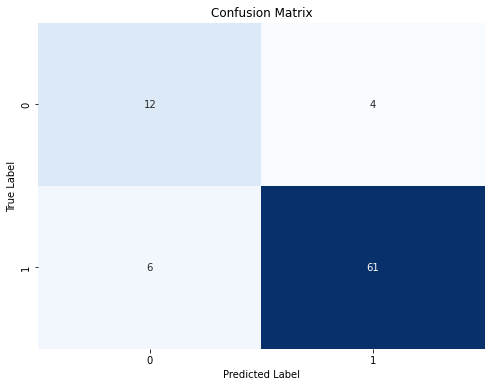

              precision    recall  f1-score   support

         0.0       0.67      0.75      0.71        16
         1.0       0.94      0.91      0.92        67

    accuracy                           0.88        83
   macro avg       0.80      0.83      0.82        83
weighted avg       0.89      0.88      0.88        83



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

with torch.no_grad():
    y_pred = model.predict(X_test)
    y_pred = y_pred.round()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_test, y_pred))

In [17]:
dl_ae_dict = {
    # 'model': model,
    'input_size': input_size,
    'learning_rate': learning_rate,
    'epochs': epochs,
    'batch_size': batch_size,
    'test_accuracy': acc,
    'test_auc': auc
}

pickle.dump(dl_ae_dict, open('dl_ae_dict.pkl', 'wb'))